In [2]:
N = 5
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
target_col = cols[N % 7]
print(target_col)

Time_on_Gaming


Итак, данные для обработки мы будем брать из столбца Time_on_Gaming датасета teen_phone_addiction_dataset.csv:

In [3]:
import pandas as pd
df = pd.read_csv('../datasets/teen_phone_addiction_dataset.csv')
data = df[target_col]
print(data)

0       1.7
1       4.0
2       1.5
3       1.6
4       0.9
       ... 
2995    1.8
2996    0.0
2997    0.2
2998    2.6
2999    2.3
Name: Time_on_Gaming, Length: 3000, dtype: float64


## I. 

In [95]:
mean = data.mean()
var = data.var()
mode = data.mode()[0]
median = data.median()
quantiles = data.quantile([0.25, 0.5, 0.75])
kurtosis = data.kurtosis()
skewness = data.skew()
iqr = quantiles[0.75] - quantiles[0.25]


print("Характеристики данных:")
print(f"1. Среднее: {mean:.4f}")
print(f"2. Дисперсия: {var:.4f}")
print(f"3. Мода: {mode:.4f}")
print(f"4. Медиана: {median:.4f}")
print(f"5. Квантили (0.25, 0.5, 0.75): {quantiles.values}")
print(f"6. Эксцесс: {kurtosis:.4f}")
print(f"7. Асимметрия: {skewness:.4f}")
print(f"8. Интерквартильный размах: {iqr:.4f}")

Характеристики данных:
1. Среднее: 1.5253
2. Дисперсия: 0.8699
3. Мода: 0.0000
4. Медиана: 1.5000
5. Квантили (0.25, 0.5, 0.75): [0.8 1.5 2.2]
6. Эксцесс: -0.4982
7. Асимметрия: 0.2590
8. Интерквартильный размах: 1.4000


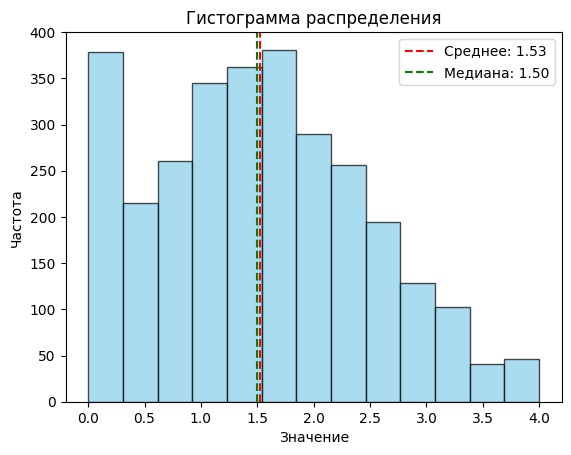

In [101]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(1, 1)

ax1.hist(data, bins=2+int(np.log2(len(data))), alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(mean, color='red', linestyle='--', label=f'Среднее: {mean:.2f}')
ax1.axvline(median, color='green', linestyle='--', label=f'Медиана: {median:.2f}')
ax1.set_title('Гистограмма распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('Частота')
ax1.legend()

Text(0, 0.5, 'F(x)')

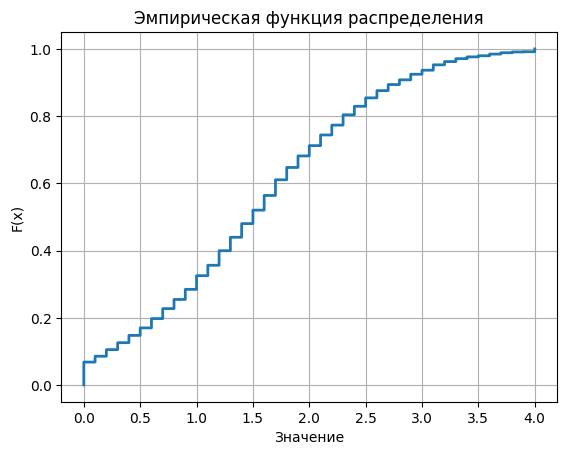

In [118]:
fig, ax1 = plt.subplots(1, 1)

sorted_data = np.sort(data)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax1.step(sorted_data, y, where='post', linewidth=2)
ax1.grid(True)
ax1.set_title('Эмпирическая функция распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('F(x)')


Исходя из полученных числовых характеристик и графиков можно сделать вывод, что распределение данных скорее напоминает бимодальное. При этом медиана и среднее значение почти не отличаются, а мода равна 0. Также, так как коээфициент ассиметрии > 0, то правый хвост распределения тяжелее, чем левый.

## II. 

In [154]:
from scipy import stats
import math

def chi_square_test(data, alpha=0.05):
    n = len(data)
    k = int(1 + 3.322 * math.log10(n))
    min_val, max_val = data.min(), data.max()
    intervals = np.linspace(min_val, max_val, k + 1)
    observed, _ = np.histogram(data, bins=intervals)
    
    mean, std = data.mean(), data.std()
    expected = np.zeros(k)
    for i in range(k):
        p = stats.norm.cdf(intervals[i+1], mean, std) - stats.norm.cdf(intervals[i], mean, std)
        expected[i] = p * n
    expected = np.where(expected == 0, 1e-10, expected)

    chi2_stat = np.sum((observed - expected)**2 / expected)
    deg = k - 3
    critical_value = stats.chi2.ppf(1 - alpha, deg)
    return chi2_stat < critical_value

In [155]:
chi2_test_result = chi_square_test(data)
print(chi2_test_result)

DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyFloatDType'>)

In [ ]:
_, p_val = stats.normaltest(data)
print(p_val)

4.76129063404915e-20


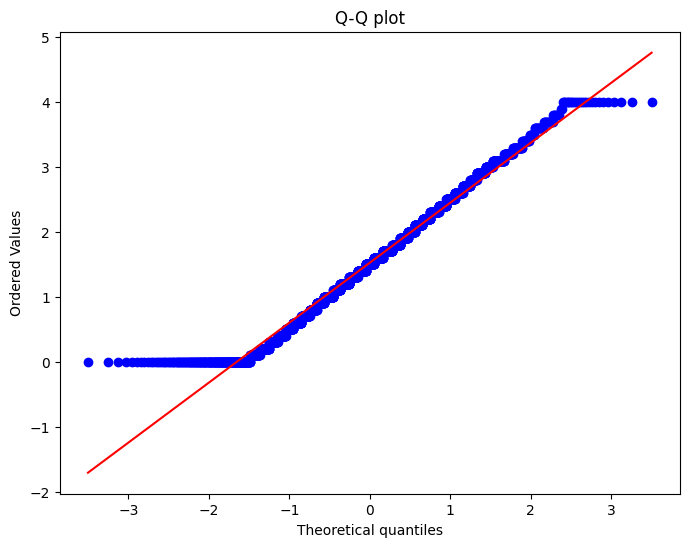

In [ ]:
plt.figure(figsize=(8, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

Исходя из результатов, оба теста на нормальность отвергают гипотезу о нормальном распределении данных. График Q-Q также показывает, что на концах наблюдаемое распределение отличается от нормального. 

## III. 

In [130]:
values = {val for val in data}
print(sorted(values))

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]


Как видно, в исходных данных выбросов не наблюдается. Попробуем применить логарифмирование и нормировку к нашим данным:

Text(0.5, 1.0, 'После нормировки')

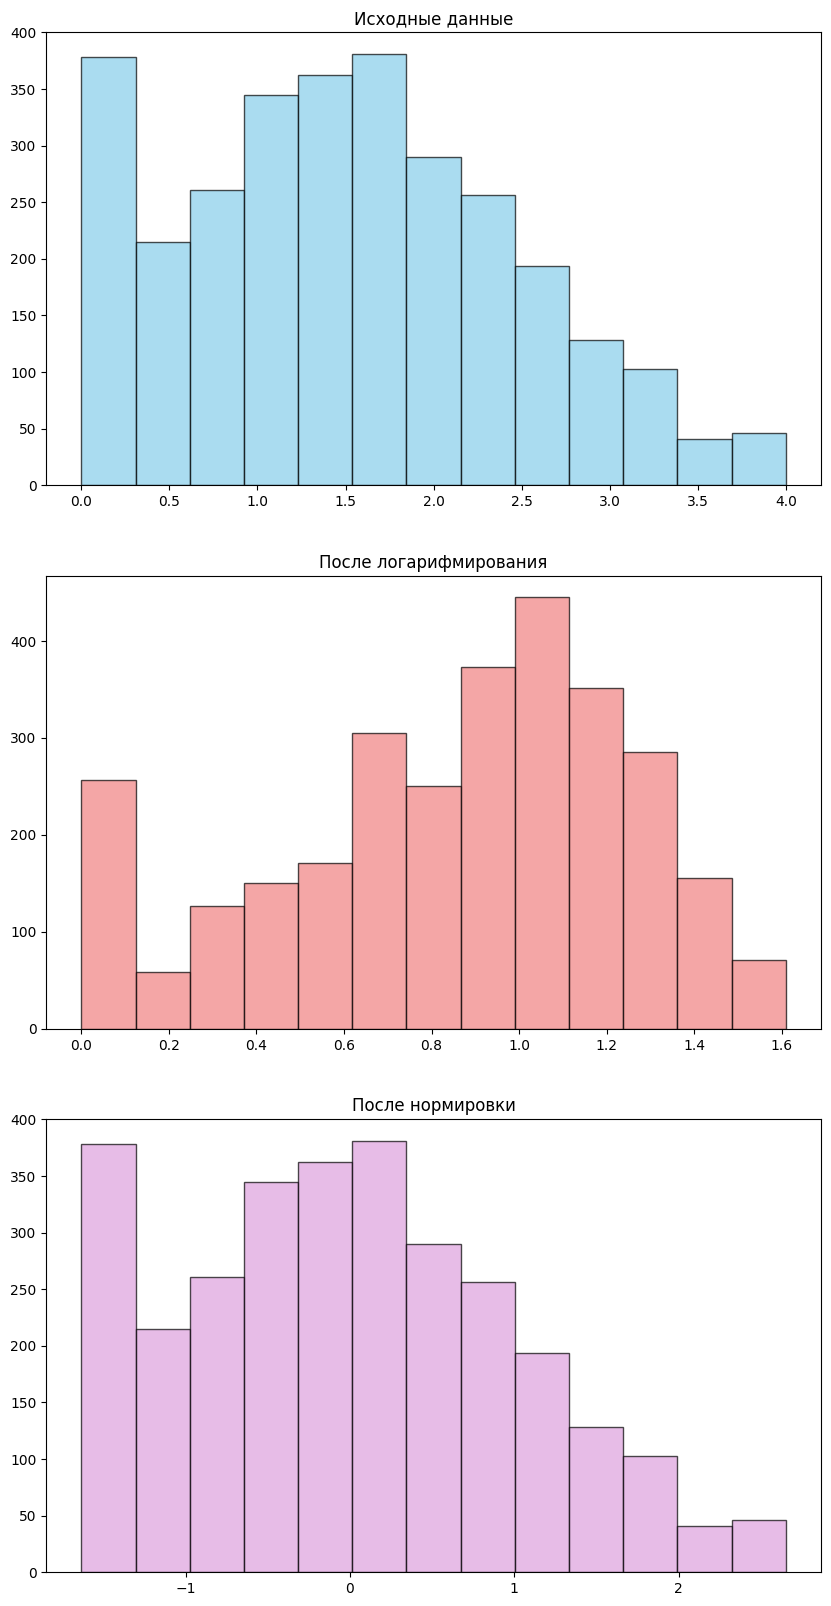

In [ ]:
log_transformed = np.log1p(data)
normalized_data = (data - data.mean()) / data.std()
bins=2+int(np.log2(len(data)))


fig, axes = plt.subplots(3, 1, figsize=(10, 20))

axes[0].hist(data, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Исходные данные')

axes[1].hist(log_transformed, bins=bins, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('После логарифмирования')

axes[2].hist(normalized_data, bins=bins, alpha=0.7, color='plum', edgecolor='black')
axes[2].set_title('После нормировки')

Как видно, нормировка не сильно повлияла на распределение, а логирифмирование привело данные к уномодальному виду (в рамках характеристик исходной гистограммы). Поэтому первые два пунка будем применять к логарифмированным данным.

In [132]:
mean = log_transformed.mean()
var = log_transformed.var()
mode = log_transformed.mode()[0]
median = log_transformed.median()
quantiles = log_transformed.quantile([0.25, 0.5, 0.75])
kurtosis = log_transformed.kurtosis()
skewness = log_transformed.skew()
iqr = quantiles[0.75] - quantiles[0.25]


print("Характеристики данных:")
print(f"1. Среднее: {mean:.4f}")
print(f"2. Дисперсия: {var:.4f}")
print(f"3. Мода: {mode:.4f}")
print(f"4. Медиана: {median:.4f}")
print(f"5. Квантили (0.25, 0.5, 0.75): {quantiles.values}")
print(f"6. Эксцесс: {kurtosis:.4f}")
print(f"7. Асимметрия: {skewness:.4f}")
print(f"8. Интерквартильный размах: {iqr:.4f}")

Характеристики данных:
1. Среднее: 0.8502
2. Дисперсия: 0.1646
3. Мода: 0.0000
4. Медиана: 0.9163
5. Квантили (0.25, 0.5, 0.75): [0.58778666 0.91629073 1.16315081]
6. Эксцесс: -0.4543
7. Асимметрия: -0.5257
8. Интерквартильный размах: 0.5754


In [136]:
chi2_test_result = chi_square_test(log_transformed)
print(chi2_test_result)

False


In [140]:
_, p_val = stats.normaltest(log_transformed)
print(p_val)

5.62407882340192e-37


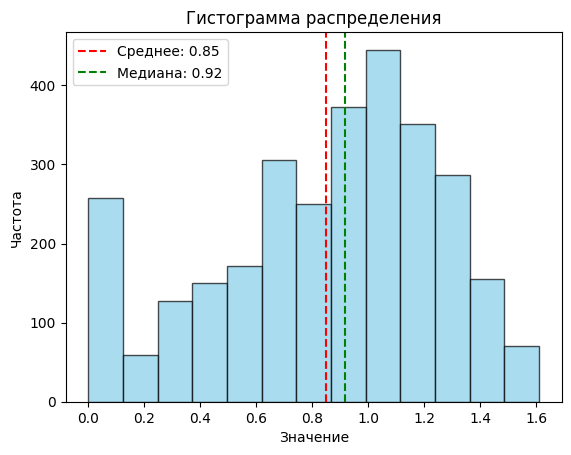

In [144]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(1, 1)

ax1.hist(log_transformed, bins=2+int(np.log2(len(data))), alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(mean, color='red', linestyle='--', label=f'Среднее: {mean:.2f}')
ax1.axvline(median, color='green', linestyle='--', label=f'Медиана: {median:.2f}')
ax1.set_title('Гистограмма распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('Частота')
ax1.legend()

Text(0, 0.5, 'F(x)')

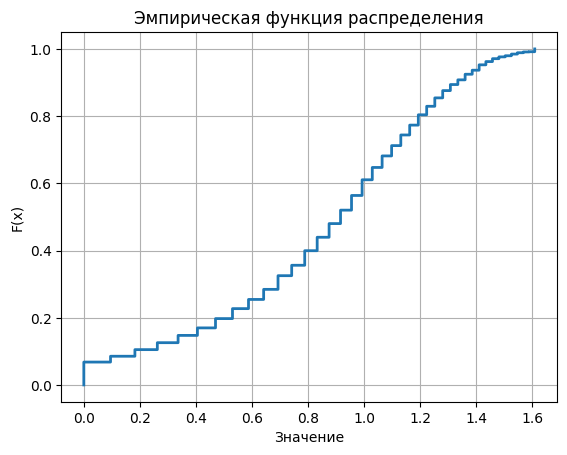

In [142]:
fig, ax1 = plt.subplots(1, 1)

sorted_data = np.sort(log_transformed)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax1.step(sorted_data, y, where='post', linewidth=2)
ax1.grid(True)
ax1.set_title('Эмпирическая функция распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('F(x)')

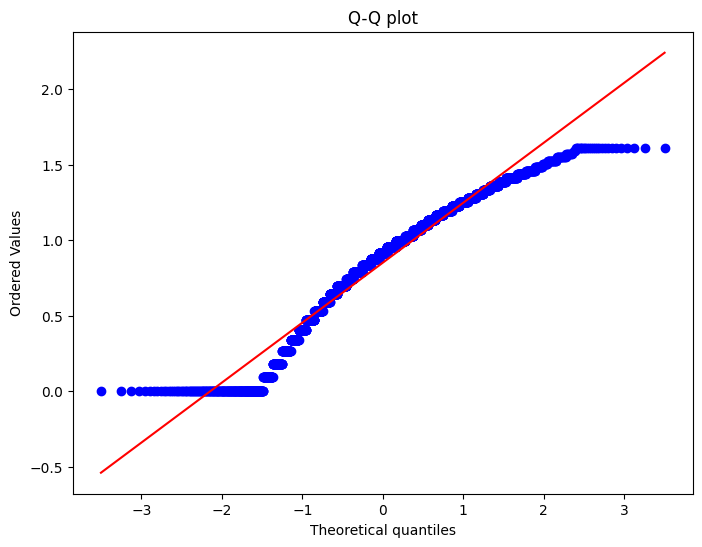

In [143]:
plt.figure(figsize=(8, 6))
stats.probplot(log_transformed, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

Исходя из результатов тестов и полученных графиков нетрудно видеть, что логарифмированные данные еще меньше напоминают нормальное распределине, чем исходные. Таким образом попытки привести данные к нормальному распределению не увенчались успехом. 

## IV.

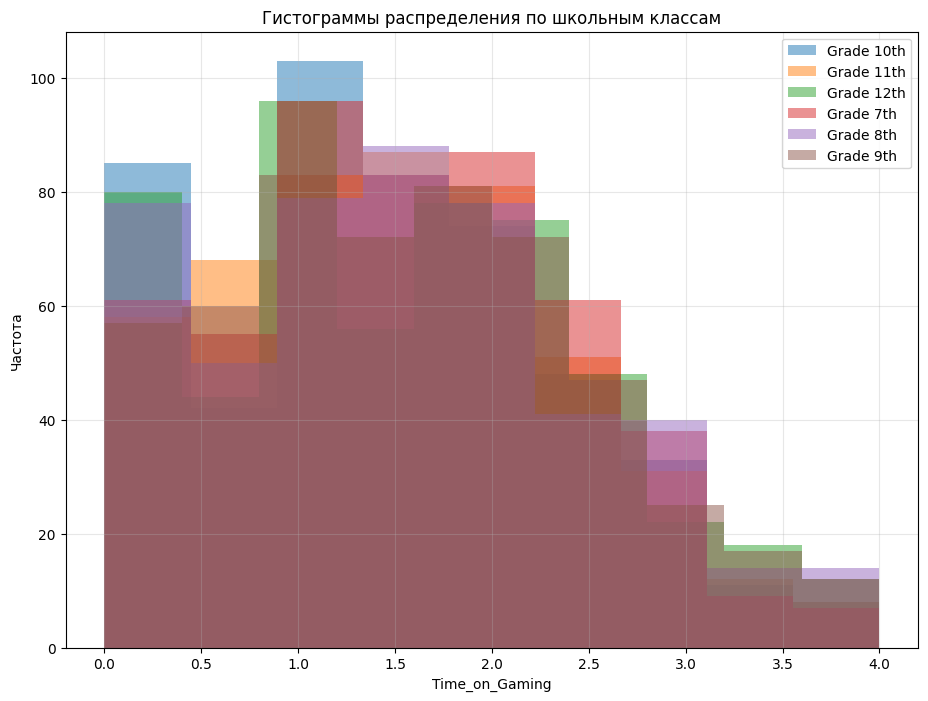

Статистики по группам:
                mean     var  count
School_Grade                       
10th          1.4532  0.8614    487
11th          1.5123  0.7876    479
12th          1.5202  0.9439    529
7th           1.5541  0.7767    497
8th           1.5386  0.9650    482
9th           1.5694  0.8799    526


In [163]:
groups = df.groupby("School_Grade")

plt.figure(figsize=(11, 8))
for grade, subset in groups:
    k = 1 + int(np.log2(len(subset))) 
    plt.hist(subset[target_col], bins=k, alpha=0.5, label=f"Grade {grade}")

plt.xlabel(target_col)
plt.ylabel("Частота")
plt.title("Гистограммы распределения по школьным классам")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

stats_by_grade = groups[target_col].agg(['mean', 'var', 'count']).round(4)
print("Статистики по группам:")
print(stats_by_grade)

Исходя из построенных гистограмм и полученным статистикам по группам можно предположить, что данные приходят из похожих (по крайней мере внешне) распределений. Хотя при этом среднее значине для 10 класса слегка выделяется на фоне остальных классов, а также дисперсия варьируется в зависимости от класса, что может указывать на возмоное влияние номера класса на время, проведенное в играх.    